# Qubit characterization tests

In [ ]:
import qiskit.pulse as pulse
import qiskit.circuit as circuit
from tergite_qiskit_connector.providers.tergite import Tergite

# import template_schedules as templates
from quantify_core.analysis import fitting_models as fm
from qiskit.visualization.pulse_v2.stylesheet import IQXDebugging
import numpy as np
import matplotlib.pyplot as plt
from quantify_core.visualization import mpl_plotting as qpl
import matplotlib.ticker as plticker
from tempfile import gettempdir
import tqcsf.file
from scipy.spatial import distance_matrix
import time
import requests
import pathlib
import functools
import rich

tuid1 = "568ebf7c-4321-44a5-ac40-22c7260cccb6"

In [ ]:
def plot_mag(ds, **kwargs):

    if "flat" in kwargs.keys():
        flat = kwargs.pop("flat")
    else:
        flat = False

    fig, axs = plt.subplots(len(ds), 1, **kwargs)
    var_peaks = dict()
    if len(ds) == 1:
        axs = [axs]

    for i, var in enumerate(ds):
        # show entire sweep on left hand side
        abs_s21 = np.abs(ds[var])

        x = ds.coords[ds.variables[var].attrs["coords"][0]]

        if flat:
            all_peaks = dict()
            for k in range(abs_s21.shape[1]):

                #                 µ = abs_s21[:,k].mean()
                #                 s = abs_s21[:,k].std()*1.3

                #                 peaks = list()
                #                 for idx_y, y in enumerate(abs_s21[:,k].data):
                #                     if y > (µ + s):
                #                         peaks.append([float(x[idx_y].data), float(y)])
                #                 all_peaks[k] = np.asarray(peaks)

                abs_s21[:, k].plot(ax=axs[i], color=f"C{k}", zorder=999 - k)
            #                 axs[i].axhline(µ + s, color = "black", alpha = 0.3)
            var_peaks[var] = all_peaks
        else:
            abs_s21.plot(ax=axs[i])

        axs[i].set_title(var)
    #         axs[i].xaxis.set_major_locator(plt.MaxNLocator(20))

    return axs, var_peaks


def plot_fit_resonator(ds):

    fig, axs = plt.subplots(len(ds), 1)

    for i, var in enumerate(ds):
        # show entire sweep on left hand side
        np.abs(ds[var]).plot(ax=axs[i])
        axs[i].set_title(var)

        x = ds.coords[ds.variables[var].attrs["coords"][0]]
        s21 = ds[var]

        # fit resonator model against the data
        model = fm.ResonatorModel()
        guess = model.guess(s21.data, f=x.data)
        fit_result = model.fit(s21, params=guess, f=x.data)

        # plot model fit
        qpl.plot_fit(
            ax=axs[i],
            fit_res=fit_result,
            plot_init=True,
            range_casting="abs",
        )
        print(var, ":", fit_result.params["fr"].value / 1e9, "GHz")

    return axs

In [ ]:
chalmers = Tergite.get_provider()
backend = chalmers.get_backend("PinguOpenPulse")
backend.set_options(shots=1000)
templates.backend = backend

In [ ]:
qubits = (0, 1, 2, 3)  # qubits to characterize

Since backend isn't finished, manually enter some data

In [ ]:
# these resonator frequencies are quite good
# r0, r1, r2, r3 are from tuid: 20220812-132155-980-0e5fbb, with job id: ba9d5d96-7328-4efd-b02c-7f4cf07a0367
# r4 is from https://qtl-team.atlassian.net/wiki/spaces/QCB/pages/2618195969/08th+Aug

# 8d70a7f1-41f9-4bd6-a68f-abd6ae9fdf18 @ 17mV:
# slot~0/acq~0 : 6.884461765134884 GHz
# slot~1/acq~0 : 6.745482508417368 GHz
# slot~2/acq~0 : 7.029379073099976 GHz
# slot~3/acq~0 : 7.187505069855161 GHz
#                                                                                                      8mV, 3µs
resonator_freqs = [
    6.884461765134884e9,
    6.745482508417368e9,
    7.029379073099976e9,
    7.187505069855161e9,
    6.66015e9,
]

# 1D resonator spectroscopy

In [ ]:
frequencies = np.asarray(
    [
        np.linspace(resonator_freqs[q] - 6e6, resonator_freqs[q] + 6e6, 600)
        for q in qubits
    ]
).transpose()

In [ ]:
param_sched = pulse.ScheduleBlock()

freq0 = circuit.Parameter(f"f drive 0")
freq1 = circuit.Parameter(f"f drive 1")
freq2 = circuit.Parameter(f"f drive 2")
freq3 = circuit.Parameter(f"f drive 3")

param_sched += pulse.SetFrequency(freq0, backend.measure_channel(0))
param_sched += pulse.SetFrequency(freq1, backend.measure_channel(1))
param_sched += pulse.SetFrequency(freq2, backend.measure_channel(2))
param_sched += pulse.SetFrequency(freq3, backend.measure_channel(3))

ro_dur = 3500
ro_amp = 17e-3

param_sched += templates.measure(0, ro_amp=ro_amp, ro_dur=ro_dur)
param_sched += templates.measure(1, ro_amp=ro_amp, ro_dur=ro_dur)
param_sched += templates.measure(2, ro_amp=ro_amp, ro_dur=ro_dur)
param_sched += templates.measure(3, ro_amp=ro_amp, ro_dur=ro_dur)

In [ ]:
sweep = [
    param_sched.assign_parameters(
        {
            freq0: f[0],
            freq1: f[1],
            freq2: f[2],
            freq3: f[3],
        },
        inplace=False,
    )
    for f in frequencies
]
print("Total schedule count in sweep:", len(sweep))

In [ ]:
sweep[10].draw(style=IQXDebugging())

In [ ]:
# compile metadata about the sweep
qobj_header = {
    "sweep": {
        "serial_order": ("frequencies",),
        "parameters": {
            "frequencies": {
                "long_name": "Frequency of readout pulse",
                "unit": "Hz",
                "slots": {q: frequencies[:, i] for i, q in enumerate(qubits)},
            }
        },
    }
}
job = backend.run(sweep, qobj_header=qobj_header)

In [ ]:
while job.status != "DONE":
    time.sleep(3)
sf = tqcsf.file.StorageFile(job.logfile, mode="r")
ds = sf.as_xarray()
ds

In [ ]:
sf = tqcsf.file.StorageFile("8d70a7f1-41f9-4bd6-a68f-abd6ae9fdf18.hdf5", mode="r")
ds = sf.as_xarray()
ds

In [ ]:
axs = plot_fit_resonator(ds)
axs[0].axhline(rs_µ0 := np.abs(ds[f"slot~{0}/acq~0"]).mean(), color="pink")
axs[1].axhline(rs_µ1 := np.abs(ds[f"slot~{1}/acq~0"]).mean(), color="pink")
axs[2].axhline(rs_µ2 := np.abs(ds[f"slot~{2}/acq~0"]).mean(), color="pink")
axs[3].axhline(rs_µ3 := np.abs(ds[f"slot~{3}/acq~0"]).mean(), color="pink")

# axs[0].axhline(rs_min0 := np.abs(ds[f"slot~{0}/acq~0"]).min(), color = "blue")
# axs[1].axhline(rs_min1 := np.abs(ds[f"slot~{1}/acq~0"]).min(), color = "blue")
# axs[2].axhline(rs_min2 := np.abs(ds[f"slot~{2}/acq~0"]).min(), color = "blue")
# axs[3].axhline(rs_min3 := np.abs(ds[f"slot~{3}/acq~0"]).min(), color = "blue")

print("rs_min0 - rs_µ0 = ", np.abs(rs_µ0).data * 1000, "mV")
print("rs_min1 - rs_µ1 = ", np.abs(rs_µ1).data * 1000, "mV")
print("rs_min2 - rs_µ2 = ", np.abs(rs_µ2).data * 1000, "mV")
print("rs_min3 - rs_µ3 = ", np.abs(rs_µ3).data * 1000, "mV")

# Qubit spectroscopy

In [ ]:
param_sched = pulse.ScheduleBlock()

freqs = list()
amps = list()
qubits = (4,)
for q in qubits:
    param_sched += pulse.SetFrequency(resonator_freqs[q], backend.measure_channel(q))
    freq = circuit.Parameter(f"f drive {q}")
    stim_amp = circuit.Parameter(f"a drive {q}")
    stim_dur = 4000
    stim_sigma = 3
    ro_dur = 3000
    ro_amp = 8e-3

    param_sched += pulse.SetFrequency(freq, backend.drive_channel(q))
    #     param_sched += templates.excite(q, stim_amp = stim_amp, stim_dur = stim_dur, stim_sigma = stim_sigma)
    param_sched += templates.excite_square(q, stim_amp=stim_amp, stim_dur=stim_dur)
    param_sched += templates.measure(q, ro_amp=ro_amp, ro_dur=ro_dur)

    freqs.append(freq)
    amps.append(stim_amp)

In [ ]:
GHz = 1e9
MHz = 1e6

# q0_center  = 6075000000
# q1_center  = 5900000000
# q2_center  = 6150000000
# q3_center  = 5800000000
q4_center = 4900000000

# q0_center = 6.173e9
# q2_center = 6.091e9
# q3_center = 5.600e9

freq_span = 144 * MHz
freq_step = 0.7 * MHz

frequencies = np.asarray(
    [
        #     np.arange(q0_center - freq_span/2, q0_center + freq_span/2, freq_step),
        #     np.arange(q1_center - freq_span/2, q1_center + freq_span/2, freq_step),
        #     np.arange(q2_center - freq_span/2, q2_center + freq_span/2, freq_step),
        #     np.arange(q3_center - freq_span/2, q3_center + freq_span/2, freq_step),
        np.arange(q4_center - freq_span / 2, q4_center + freq_span / 2, freq_step),
    ]
).transpose()
amplitudes = np.asarray(
    [
        #     np.linspace(0.3e-3, 3e-3, 10),
        #     np.linspace(0.3e-3, 3e-3, 10),
        #     np.linspace(0.3e-3, 3e-3, 10),
        np.linspace(4e-3, 20e-3, 15),
    ]
).transpose()
print("That will be:", frequencies.shape[0] * amplitudes.shape[0], "schedules")

In [ ]:
%matplotlib inline
sweep = [
    param_sched.assign_parameters(
        {freq: f[i] for i, freq in enumerate(freqs)}
        | {amp: a[i] for i, amp in enumerate(amps)},
        inplace=False,
    )
    for f in frequencies
    for a in amplitudes
]
print("Total schedule count in sweep:", len(sweep))

In [ ]:
sweep[2000].draw(style=IQXDebugging())

In [ ]:
# compile metadata about the sweep
qobj_header = {
    "sweep": {
        "serial_order": ("frequencies", "amplitudes"),
        "parameters": {
            "frequencies": {
                "long_name": "Frequency of drive pulse",
                "unit": "Hz",
                "slots": {q: frequencies[:, i] for i, q in enumerate(qubits)},
            },
            "amplitudes": {
                "long_name": "Amplitude of drive pulse",
                "unit": "V",
                "slots": {q: amplitudes[:, i] for i, q in enumerate(qubits)},
            },
        },
    }
}
job = backend.run(sweep, qobj_header=qobj_header)

In [ ]:
job.status

In [ ]:
while job.status != "DONE":
    time.sleep(5)
sf = tqcsf.file.StorageFile(job.logfile, mode="r")
print("File location: ", pathlib.Path(gettempdir()) / sf.job_id)
ds = sf.as_xarray()
ds

In [ ]:
ow_tuid = "476764bf-2ed4-48ec-bf88-225c36f2763c"
ow_tuid = "73a5b6ff-8506-4747-8396-084b59b15241"
ow_tuid = "5a8b6c49-a52c-4107-8f17-0f78262e8ec3"
ow_tuid = "476764bf-2ed4-48ec-bf88-225c36f2763c"
ow_tuid = "73a5b6ff-8506-4747-8396-084b59b15241"
ow_tuid = "73a5b6ff-8506-4747-8396-084b59b15241"
ow_tuid = "965047e7-da22-40ae-b1a8-05f1b1840591"
ow_tuid = "965047e7-da22-40ae-b1a8-05f1b1840591"
ow_tuid = "abbc4a62-f3dd-46a1-8d2f-ec90bc475523"
sf = tqcsf.file.StorageFile(f"{ow_tuid}.hdf5", mode="a")

In [ ]:
sf.header["qobj/sweep/parameters/amplitudes/slots"].create_dataset(
    name="slot~1",
    shape=sf.header["qobj/sweep/parameters/amplitudes/slots/slot~0"].shape,
    dtype=sf.header["qobj/sweep/parameters/amplitudes/slots/slot~0"].dtype,
)
sf.header["qobj/sweep/parameters/amplitudes/slots/slot~1"][...] = sf.header[
    "qobj/sweep/parameters/amplitudes/slots/slot~0"
][:]

In [ ]:
s = "qobj/sweep/parameters/frequencies/slots"
s0 = s + "/slot~0"
# sf.header[s].create_dataset(name = "slot~1", shape = sf.header[s0].shape, dtype = sf.header[s0].dtype)
for q in qubits:
    sf.header[s + f"/slot~{q}"][...] = frequencies[:, q]

In [ ]:
sf.header[s0][:]

In [ ]:
# ow_tuid = "ec83c006-5e1c-4fa6-81a0-f3a63de0561b"
# ow_tuid = "e4c1c501-304d-4a08-a677-6994f3d55e07"
# ow_tuid = "7e36443a-fa5e-4716-9176-4be217550580"
# ow_tuid = "476764bf-2ed4-48ec-bf88-225c36f2763c"
# sf = tqcsf.file.StorageFile(f"{ow_tuid}.hdf5", mode = "r")

# q0_center  = 6075000000
# q1_center  = 5900000000
# q2_center  = 6150000000
# q3_center  = 5800000000

ds = sf.as_xarray()
ds

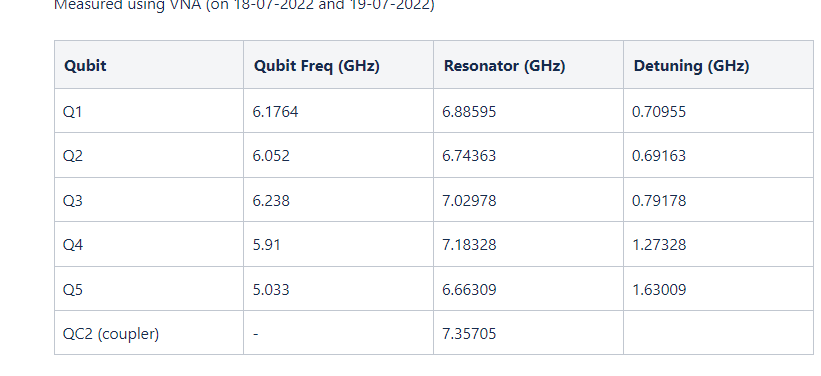

In [ ]:
%matplotlib notebook
# rs_min0 - rs_µ0 =  8.80309002154728 mV
# rs_min1 - rs_µ1 =  4.809334641021828 mV
# rs_min2 - rs_µ2 =  7.81497577653904 mV
# rs_min3 - rs_µ3 =  3.5735241012736476 mV

axs, peaks = plot_mag(ds, flat=False, sharex=True)
# axs[0].set_xlabel("")
# axs[0].axvline(6.1764e9, color = "red")
# # axs[0].axhline(8.80309002154728/1000, color = "red")
# axs[1].set_xlabel("")
# axs[1].axvline(6.052e9, color = "red")
# # axs[1].axhline(4.809334641021828/1000, color = "red")
# axs[2].set_xlabel("")
# axs[2].axvline(6.238e9, color = "red")
# # axs[2].axhline(7.81497577653904/1000, color = "red")
# axs[3].axvline(5.91e9, color = "red")
# # axs[3].axhline(3.5735241012736476/1000, color = "red")

In [ ]:
data[143], data[112]

In [ ]:
# 7e36443a-fa5e-4716-9176-4be217550580
# pinkline : LO, blue line: Pingu A VNA freq, red line: expected freq, 0mV, 1.5mV, 3mV, Gaussian pulse, 300ns, 60ns sigma (edited)
# q0_res = 6.174e9
# q2_res = 6.091e9
# q3_res = 5.600e9

In [ ]:
%matplotlib notebook
fig, ax = plt.subplots()
abs_s21 = np.abs(ds["slot~3/acq~0"])[:, -5]
abs_s21.plot(ax=ax)
µ = abs_s21.mean().data
σ = abs_s21.std().data
m = abs_s21.max().data
ax.axhline(µ, color="pink")
# ax.axhline(µ-σ, color = "green")
# ax.axhline(µ+σ, color = "green")
ax.axhline(m, color="blue")

print("||m - (µ - σ) ||\t= ", abs(m - µ + σ) * 1000, "mV")
print("||m - µ||\t\t= ", abs(m - µ) * 1000, "mV")
print("||m - (µ + σ) ||\t= ", abs(m - µ - σ) * 1000, "mV")